#1. Carga de datos

## 1.1 Importar librerías

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import joblib
from matplotlib import pyplot as plt
import cv2
import seaborn as sns
from google.colab import drive

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn import metrics
from sklearn.metrics import (
    roc_curve, auc, RocCurveDisplay,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report , roc_auc_score
)
from sklearn.utils import class_weight

import keras_tuner as kt

import os

## 1.2 Cargar bases de datos procesadas

Mounted at /content/drive


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
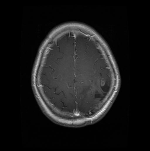

In [ ]:
drive.mount('/content/drive')
x_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_test.pkl')

x_train[0]

In [ ]:
# Conversión a float32 para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
# Escalado entre 0 y 1
x_train /= 255
x_test /= 255

In [ ]:
# Visualizar forma de las imagenes para luego convertir a 1D
print("Shape x_train:", x_train.shape)
print("Shape x_test:", x_test.shape)

Shape x_train: (5712, 151, 150, 3)
Shape x_test: (1311, 151, 150, 3)


In [ ]:
np.prod(x_train[1].shape) # cantidad de variables por imagen

np.int64(67950)

In [ ]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3]), array([300, 306, 300, 405]))

#2. Modelos

##2.1 Red Neuronal Convolucional NNC

In [ ]:
# Cantidad de clases
num_classes = len(np.unique(y_train))
print(f"Número de clases detectadas: {num_classes}")

cnn_model = Sequential()

# Primera capa convolucional y de pooling
# input_shape es solo para la primera capa
# Conv2D: 32 filtros, tamaño del filtro 3x3, activación ReLU
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:]))
# MaxPooling2D: Ventana de pooling 2x2. Reduce la resolución a la mitad.
cnn_model.add(MaxPooling2D((2, 2)))

# Segunda capa convolucional y de pooling
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Aplanar la salida de las capas convolucionales antes de las capas densas
cnn_model.add(Flatten())

# Capas densas
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))

# Capa de salida para clasificación multiclase (con softmax y num_classes)
cnn_model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']) # Añadir más métricas si deseamos, como AUC, Recall, Precision

# Mostrar un resumen de la arquitectura del modelo
cnn_model.summary()

# Guardar el mejor modelo
checkpoint = ModelCheckpoint("mejor_cnn_modelo.keras", monitor="val_accuracy", save_best_only=True, mode='max', verbose=1)

# Entrenamiento
history = cnn_model.fit(x_train, y_train,
                        batch_size=100,
                        epochs=5,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])

Número de clases detectadas: 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 149, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,644,868 (40.61 MB)

 Trainable params: 10,644,868 (40.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5882 - loss: 0.9381
Epoch 1: val_accuracy improved from -inf to 0.81617, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step - accuracy: 0.5904 - loss: 0.9341 - val_accuracy: 0.8162 - val_loss: 0.4878
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8620 - loss: 0.3591
Epoch 2: val_accuracy improved from 0.81617 to 0.88024, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.8622 - loss: 0.3587 - val_accuracy: 0.8802 - val_loss: 0.3036
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9251 - loss: 0.2102
Epoch 3: val_accuracy improved from 0.88024 to 0.90084, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.9251 - loss: 0.2101 - val_accuracy: 0.9008 - val_loss: 0.2673
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9640 - loss: 0.1178
Epoch 4: val_accuracy improved from 0.9008

In [ ]:
# Obtener las probabilidades de predicción para el modelo CNN en el conjunto de prueba
# El modelo CNN con activación softmax en la capa de salida ya produce probabilidades
y_pred_proba_cnn = cnn_model.predict(x_test)

# Calcular el AUC utilizando las probabilidades predichas y las etiquetas reales
# Usamos multi_class='ovr' y average='macro' para manejar clasificación multiclase
try:
    roc_auc_cnn = roc_auc_score(y_test, y_pred_proba_cnn, multi_class='ovr', average='macro')
    print(f"AUC para el modelo CNN en el conjunto de prueba: {roc_auc_cnn:.4f}")
except ValueError as e:
    print(f"No se pudo calcular el AUC para el modelo CNN. Error: {e}")
    print("Esto puede ocurrir si hay clases que no aparecen en las predicciones o en los datos reales.")

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step
AUC para el modelo CNN en el conjunto de prueba: 0.9927


In [ ]:
checkpoint

In [ ]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = cnn_model.evaluate(x_test, y_test, verbose=0)

# Imprimir los resultados de la evaluación
print(f"Loss en los datos de prueba: {loss:.4f}")
print(f"Precisión en los datos de prueba: {accuracy:.4f}")
print(f"AUC en los datos de prueba: {roc_auc_cnn:.4f}")

Loss en los datos de prueba: 0.1903
Precisión en los datos de prueba: 0.9397
AUC en los datos de prueba: 0.9927


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step


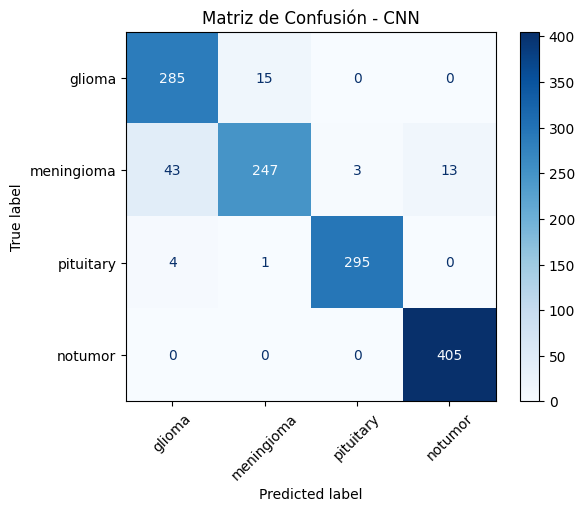

In [ ]:
# Obtener las predicciones del modelo CNN en el conjunto de prueba
y_pred_cnn = np.argmax(cnn_model.predict(x_test), axis=-1)

# Definir las etiquetas de las clases (asegurarse de que coincidan con el orden)
class_labels =  ['glioma', 'meningioma', 'notumor', 'pituitary']

# Matriz de confusión para el modelo CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn, labels=[0, 1, 2, 3])

# Visualizar la matriz de confusión
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_labels)
disp_cnn.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - CNN")
plt.show()

##2.2 Regularización L2 y Dropout

In [ ]:
# Hiperparámetros
reg_strength = 0.001
dropout_rate = 0.3
num_classes = len(np.unique(y_train))

# Definición del modelo CNN
cnn_model2 = Sequential([
    Input(shape=x_train.shape[1:]),

    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(reg_strength)),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(reg_strength)),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),

    Flatten(),

    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(reg_strength)),
    Dropout(dropout_rate),

    Dense(num_classes, activation='softmax')  # Salida multiclase
])

# Compilación
cnn_model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Mostrar arquitectura
cnn_model2.summary()

# Callbacks
checkpoint = ModelCheckpoint("mejor_cnn_multiclase.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="max",
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5,
                           restore_best_weights=True, verbose=1)

# Entrenamiento
history = cnn_model2.fit(
    x_train, y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, early_stop],
    verbose=2
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 151, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,627,140 (21.47 MB)

 Trainable params: 5,627,140 (21.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.70175, saving model to mejor_cnn_multiclase.keras
90/90 - 231s - 3s/step - accuracy: 0.5140 - loss: 1.3374 - val_accuracy: 0.7018 - val_loss: 0.9206
Epoch 2/10

Epoch 2: val_accuracy improved from 0.70175 to 0.78642, saving model to mejor_cnn_multiclase.keras
90/90 - 255s - 3s/step - accuracy: 0.7442 - loss: 0.7873 - val_accuracy: 0.7864 - val_loss: 0.6804
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.78642
90/90 - 267s - 3s/step - accuracy: 0.8032 - loss: 0.6517 - val_accuracy: 0.6865 - val_loss: 0.7873
Epoch 4/10

Epoch 4: val_accuracy improved from 0.78642 to 0.82304, saving model to mejor_cnn_multiclase.keras
90/90 - 258s - 3s/step - accuracy: 0.8211 - loss: 0.5913 - val_accuracy: 0.8230 - val_loss: 0.5663
Epoch 5/10

Epoch 5: val_accuracy improved from 0.82304 to 0.84516, saving model to mejor_cnn_multiclase.keras
90/90 - 252s - 3s/step - accuracy: 0.8456 - loss: 0.5568 - val_accuracy: 0.8452 - val_loss: 0.5454
E

In [ ]:
# Obtener las probabilidades de predicción para el modelo CNN2 en el conjunto de prueba
y_pred_proba_cnn2 = cnn_model2.predict(x_test)

# Calcular el AUC utilizando las probabilidades predichas y las etiquetas reales
try:
    roc_auc_cnn2 = roc_auc_score(y_test, y_pred_proba_cnn2, multi_class='ovr', average='macro')
except ValueError as e:
    print(f"No se pudo calcular el AUC para el modelo CNN2. Error: {e}")
    print("Esto puede ocurrir si hay clases que no aparecen en las predicciones o en los datos reales.")
    roc_auc_cnn2 = None

# Evaluar el modelo en los datos de prueba
loss2, accuracy2 = cnn_model2.evaluate(x_test, y_test, verbose=0)

# Imprimir los resultados de la evaluación
print(f"Loss en los datos de prueba: {loss2:.4f}")
print(f"Precisión en los datos de prueba: {accuracy2:.4f}")
if roc_auc_cnn2 is not None:
    print(f"AUC en los datos de prueba: {roc_auc_cnn2:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 438ms/step
Loss en los datos de prueba: 0.4459
Precisión en los datos de prueba: 0.8749
AUC en los datos de prueba: 0.9809


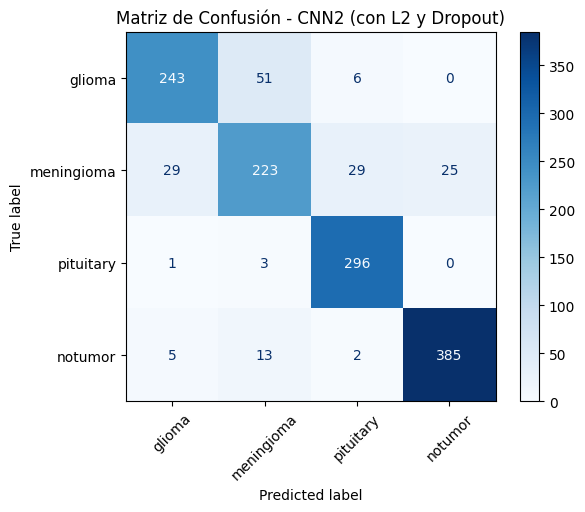

In [ ]:
# Obtener las predicciones del modelo CNN2 en el conjunto de prueba
y_pred_cnn2 = np.argmax(y_pred_proba_cnn2, axis=-1)

# Definir las etiquetas de las clases (asegurarse de que coincidan con el orden)
class_labels =  ['glioma', 'meningioma', 'notumor', 'pituitary']

# Matriz de confusión para el modelo CNN2
cm_cnn2 = confusion_matrix(y_test, y_pred_cnn2, labels=[0, 1, 2, 3])

# Visualizar la matriz de confusión
disp_cnn2 = ConfusionMatrixDisplay(confusion_matrix=cm_cnn2, display_labels=class_labels)
disp_cnn2.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - CNN2 (con L2 y Dropout)")
plt.show()

## 2.3 Búsqueda de hiperparámetros

In [ ]:
def build_model(hp):
    # Hiperparámetros a buscar
    dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    reg_strength = hp.Float("l2", min_value=0.0001, max_value=0.01, sampling="log")
    filters = hp.Int('filters', min_value=16, max_value=64, step=16)
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=x_train.shape[1:]),

        tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Conv2D(filters * 2, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Definir tuner
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_accuracy', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_multiclase'
)

# Mostrar búsqueda
tuner.search_space_summary()

# Buscar
tuner.search(x_train, y_train,
             epochs=10,
             batch_size=64,
             validation_data=(x_test, y_test),
             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
             verbose=2)

Trial 2 Complete [00h 43m 15s]
val_accuracy: 0.8512585759162903

Best val_accuracy So Far: 0.8695651888847351
Total elapsed time: 01h 26m 34s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.5               |0.5               |dropout
0.00015332        |0.0069402         |l2
48                |32                |filters
64                |128               |dense_units

Epoch 1/10
90/90 - 380s - 4s/step - accuracy: 0.4529 - loss: 1.2726 - val_accuracy: 0.6651 - val_loss: 0.9555
Epoch 2/10
90/90 - 385s - 4s/step - accuracy: 0.6366 - loss: 0.8879 - val_accuracy: 0.7117 - val_loss: 0.8182
Epoch 3/10
90/90 - 372s - 4s/step - accuracy: 0.7055 - loss: 0.7225 - val_accuracy: 0.7895 - val_loss: 0.5783
Epoch 4/10
90/90 - 360s - 4s/step - accuracy: 0.7456 - loss: 0.6270 - val_accuracy: 0.7666 - val_loss: 0.5568
Epoch 5/10
90/90 - 397s - 4s/step - accuracy: 0.7799 - loss: 0.5533 - val_accuracy: 0.8192 - val_loss: 0.4464
Epoch 6/10
90/90 - 358s - 4s/step - accuracy

KeyboardInterrupt: 

In [ ]:
# Obtener el mejor modelo
cnn_model3 = tuner.get_best_models(num_models=1)[0]
cnn_model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 151, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,234,884 (42.86 MB)

 Trainable params: 11,234,884 (42.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Obtener las probabilidades de predicción para el mejor modelo (CNN3) en el conjunto de prueba
y_pred_proba_cnn3 = cnn_model3.predict(x_test)

# Calcular el AUC utilizando las probabilidades predichas y las etiquetas reales
try:
    roc_auc_cnn3 = roc_auc_score(y_test, y_pred_proba_cnn3, multi_class='ovr', average='macro')
except ValueError as e:
    print(f"No se pudo calcular el AUC para el modelo CNN3. Error: {e}")
    print("Esto puede ocurrir si hay clases que no aparecen en las predicciones o en los datos reales.")
    roc_auc_cnn3 = None

# Evaluar el mejor modelo en los datos de prueba
loss3, accuracy3 = cnn_model3.evaluate(x_test, y_test, verbose=0)

# Imprimir los resultados de la evaluación
print(f"Loss en los datos de prueba: {loss3:.4f}")
print(f"Precisión en los datos de prueba: {accuracy3:.4f}")
if roc_auc_cnn3 is not None:
    print(f"AUC en los datos de prueba: {roc_auc_cnn3:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step
Loss en los datos de prueba: 0.3796
Precisión en los datos de prueba: 0.8696
AUC en los datos de prueba: 0.9826


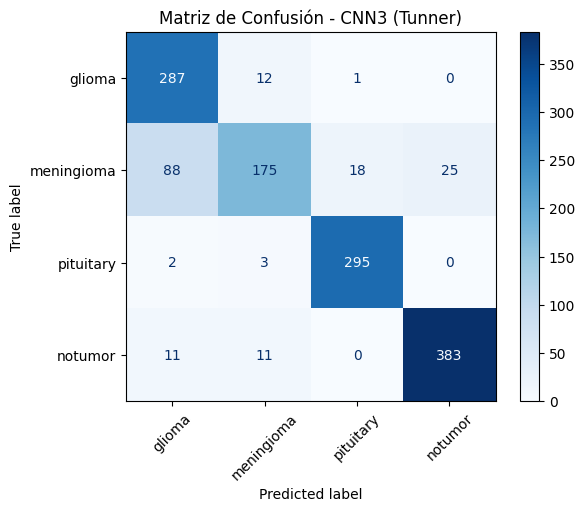

In [ ]:
# Obtener las predicciones del modelo CNN2 en el conjunto de prueba
y_pred_cnn3 = np.argmax(y_pred_proba_cnn3, axis=-1)

# Definir las etiquetas de las clases (asegurarse de que coincidan con el orden)
class_labels =  ['glioma', 'meningioma', 'notumor', 'pituitary']

# Matriz de confusión para el modelo CNN2
cm_cnn3 = confusion_matrix(y_test, y_pred_cnn3, labels=[0, 1, 2, 3])

# Visualizar la matriz de confusión
disp_cnn3 = ConfusionMatrixDisplay(confusion_matrix=cm_cnn3, display_labels=class_labels)
disp_cnn3.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - CNN3 (Tunner)")
plt.show()

# Exportar mejor modelo

In [ ]:
# Crear DataFrame de comparación solo para los dos modelos CNN
data_cnn = {
    'Modelo': ['CNN (base)', 'CNN (L2 + Dropout)', 'CNN (Búsquedad Hiperparámetros)'],
    'Accuracy (Test)': [accuracy, accuracy2, accuracy3],
    'AUC (Test)': [roc_auc_cnn, roc_auc_cnn2, roc_auc_cnn3],
    'Loss (Test)': [loss, loss2, loss3]
}

df_cnn_comparison = pd.DataFrame(data_cnn)

# Mostrar la tabla comparativa
print("Comparación de rendimiento entre modelos CNN:")
display(df_cnn_comparison)

Comparación de rendimiento entre modelos CNN:


,Modelo,Accuracy (Test),AUC (Test),Loss (Test)
0,CNN (base),0.939741,0.992686,0.190304
1,CNN (L2 + Dropout),0.874905,0.980863,0.445855
2,CNN (Búsquedad Hiperparámetros),0.869565,0.982555,0.379555


In [ ]:
# Exportar modelo con optimización de hiperparámetros
os.makedirs('salidas', exist_ok=True)
cnn_model3.save('/content/drive/MyDrive/cod/A3_helath/data/salidas/best_model.keras')